In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_tavily import TavilySearch
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage
from pydantic import BaseModel
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from typing import Annotated

os.environ["TAVILY_API_KEY"] =os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] =os.getenv("GROQ_API_KEY")


In [ ]:
arxiv_api_wrapper = ArxivAPIWrapper(top_k_results=3, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=arxiv_api_wrapper)
print(arxiv.name)
arxiv.invoke("Attention all you need")

In [ ]:
wiki_api_wrapper =WikipediaAPIWrapper(top_k_results=3,doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=wiki_api_wrapper)
wiki.invoke("Tell me about oct 7th 2023")

In [ ]:
tavily_serach = TavilySearch(max_results=5)
response = tavily_serach.invoke({"query":"What happed on Oct 7th 2023 at Nova music festival"})
print(response)


In [27]:
def add(a:int,b:int):
    """This fucntion will take two int arugment and add them and return the sum
    Args:
    a: int
    b: int

    """
    return a+b

In [28]:
tools =[arxiv,wiki,tavily_serach,add]

In [29]:
llm = ChatGroq(model="qwen/qwen3-32b")
llm_withtools = llm.bind_tools(tools)

In [ ]:
llm_withtools.invoke([HumanMessage(content="What is the result of recent india pak war and what is sum of 2 & 2")])

In [33]:
class State(TypedDict):
   messages:Annotated[list[AnyMessage],add_messages]

In [34]:
def tool_calling(State:State):
    return {"messages":llm_withtools.invoke(State["messages"])}

In [40]:
builder = StateGraph(State)

builder.add_node("tool_call_llm",tool_calling)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START, "tool_call_llm")
builder.add_conditional_edges(
        "tool_call_llm",
        tools_condition
        )
builder.add_edge("tools",END)



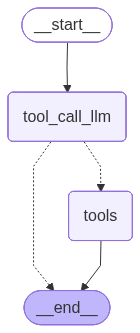

In [41]:
builder.compile()

In [44]:
graph= builder.compile()

In [ ]:
messages = graph.invoke()

BadRequestError: Error code: 400 - {'error': {'message': "'messages' : minimum number of items is 1", 'type': 'invalid_request_error'}}